In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
try:
    reload(galpy.df_src.streampepperdf)
    reload(galpy.df_src.streampepperdf.galpy.df_src.streamgapdf)
except NameError:
    import galpy.df_src.streampepperdf
import numpy
from scipy import signal, ndimage
from galpy.potential import LogarithmicHaloPotential
from galpy.orbit import Orbit
from galpy.actionAngle import actionAngleIsochroneApprox
from galpy.util import bovy_conversion, bovy_coords
from galpy.util import bovy_plot
%pylab inline
import seaborn as sns
R0, V0= 8., 220.

Populating the interactive namespace from numpy and matplotlib


# Computing stream peppering with *galpy*

We again work with the stream model from Sanders, Bovy, & Erkal (2015) as a baseline. We compute the combined effect of two impacts at the same time, but 1 radian in parallel angle apart (both are $10^8\,M_\odot$). The probability $p(\Omega_\parallel,\theta_\parallel)$ and the mean are given by:

In [3]:
lp= LogarithmicHaloPotential(normalize=1.,q=0.9)
xv_prog_init= numpy.array([30.,0.,0.,0., 105.74895, 105.74895])
def convert_to_cylindrical(xv):
    R,phi,Z= bovy_coords.rect_to_cyl(xv[:,0],xv[:,1],xv[:,2])
    vR,vT,vZ= bovy_coords.rect_to_cyl_vec(xv[:,3],xv[:,4],xv[:,5],R,phi,Z,cyl=True)
    out= numpy.empty_like(xv)
    # Preferred galpy arrangement of cylindrical coordinates
    out[:,0]= R
    out[:,1]= vR
    out[:,2]= vT
    out[:,3]= Z
    out[:,4]= vZ
    out[:,5]= phi
    return out
sigv= 0.365*(10./2.)**(1./3.)
RvR_prog_init= convert_to_cylindrical(xv_prog_init[:,numpy.newaxis].T)[0,:]
prog_init= Orbit([RvR_prog_init[0]/R0,RvR_prog_init[1]/V0,RvR_prog_init[2]/V0,
                  RvR_prog_init[3]/R0,RvR_prog_init[4]/V0,RvR_prog_init[5]])
times= numpy.linspace(0.,10.88/bovy_conversion.time_in_Gyr(V0,R0),10001)
prog_init.integrate(times,lp)
xv_unp_peri_prog= [prog_init.x(times[-1])[0],prog_init.y(times[-1])[0],prog_init.z(times[-1]),
              prog_init.vx(times[-1])[0],prog_init.vy(times[-1])[0],prog_init.vz(times[-1])]
RvR_unp_peri_prog= convert_to_cylindrical(numpy.array(xv_unp_peri_prog)[:,numpy.newaxis].T)[0,:]
prog_unp_peri= Orbit([RvR_unp_peri_prog[0],RvR_unp_peri_prog[1],RvR_unp_peri_prog[2],
                      RvR_unp_peri_prog[3]+0.0,RvR_unp_peri_prog[4],RvR_unp_peri_prog[5]])
aAI= actionAngleIsochroneApprox(pot=lp,b=0.8)

In [4]:
sdf_pepper= galpy.df_src.streampepperdf.streampepperdf(\
    sigv/V0,progenitor=prog_unp_peri,pot=lp,aA=aAI,
    leading=False,nTrackChunks=26,nTrackIterations=1,
    sigMeanOffset=4.5,
    tdisrupt=10.88/bovy_conversion.time_in_Gyr(V0,R0),
    Vnorm=V0,Rnorm=R0,
    impactb=[0.,0.],
    subhalovel=numpy.array([[6.82200571,132.7700529,149.4174464],
                            [6.82200571,132.7700529,149.4174464]])/V0, # from Denis' email
    timpact=[2.88/bovy_conversion.time_in_Gyr(V0,R0),2.88/bovy_conversion.time_in_Gyr(V0,R0)],
    impact_angle=[-1.34,-0.34],
    GM=[10.**-2./bovy_conversion.mass_in_1010msol(V0,R0),10.**-2./bovy_conversion.mass_in_1010msol(V0,R0)],
    rs=[0.625/R0,0.625/R0]) 

In [5]:
xs= numpy.linspace(0.,4.5,101)
mO= numpy.array([sdf_pepper.meanOmega(x,oned=True) for x in xs])
mO_unp= numpy.array([super(galpy.df_src.streampepperdf.streampepperdf,sdf_pepper).meanOmega(x,oned=True) for x in xs])

/Users/bovy/anaconda/lib/python2.7/site-packages/scipy/integrate/quadpack.py:352: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)



/Users/bovy/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):



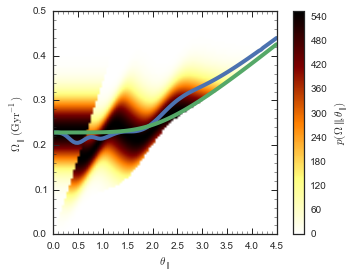

In [6]:
Opars= numpy.linspace(0.,0.5,101)/bovy_conversion.freq_in_Gyr(V0,R0)
apars= numpy.linspace(0.,4.5,101)
y= numpy.array([sdf_pepper.pOparapar(Opars,a) for a in apars])
bovy_plot.bovy_dens2d(y.T,
                      origin='lower',
                      cmap='afmhot_r',colorbar=True,
                      vmin=0.,
                      xrange=[apars[0],apars[-1]],
                      yrange=[Opars[0]*bovy_conversion.freq_in_Gyr(V0,R0),
                              Opars[-1]*bovy_conversion.freq_in_Gyr(V0,R0)],
                     zlabel=r'$p(\Omega\parallel,\theta_\parallel)$')
plot(xs,mO*bovy_conversion.freq_in_Gyr(V0,R0),lw=4.)
plot(xs,mO_unp*bovy_conversion.freq_in_Gyr(V0,R0),lw=4.)
xlabel(r'$\theta_\parallel$')
ylabel(r'$\Omega_\parallel\,(\mathrm{Gyr}^{-1})$')

The density along the stream is

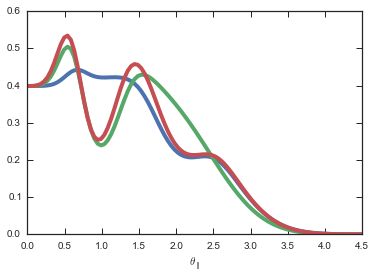

In [7]:
xs= numpy.linspace(0.,4.5,101)
dens= numpy.array([sdf_pepper._sgapdfs[0].density_par(x) for x in xs])
plot(xs,dens/numpy.sum(dens)/(xs[1]-xs[0]),lw=4.)
dens= numpy.array([sdf_pepper._sgapdfs[1].density_par(x) for x in xs])
plot(xs,dens/numpy.sum(dens)/(xs[1]-xs[0]),lw=4.)
dens= numpy.array([sdf_pepper.density_par(x) for x in xs])
plot(xs,dens/numpy.sum(dens)/(xs[1]-xs[0]),lw=4.)
xlabel(r'$\theta_\parallel$')

Let's try the same for two $10^5\,M_\odot$ impacts. Can we get the frequency deviation accurately with this code? The frequency deviation is

In [8]:
sdf_pepper.set_impacts(impact_angle=[-1.34,-0.34],impactb=[0.,0.],
                       subhalovel=numpy.array([[6.82200571,132.7700529,149.4174464],
                                               [6.82200571,132.7700529,149.4174464]])/V0,
                       timpact=[2.88/bovy_conversion.time_in_Gyr(V0,R0),
                                2.88/bovy_conversion.time_in_Gyr(V0,R0)],
                       GM=[10.**-5./bovy_conversion.mass_in_1010msol(V0,R0),
                           10.**-5./bovy_conversion.mass_in_1010msol(V0,R0)],
                       rs=[0.625/R0,0.625/R0])

In [9]:
xs= numpy.linspace(0.,4.5,101)
mO= numpy.array([sdf_pepper.meanOmega(x,oned=True) for x in xs])
mO_unp= numpy.array([super(galpy.df_src.streampepperdf.streampepperdf,sdf_pepper).meanOmega(x,oned=True) for x in xs])

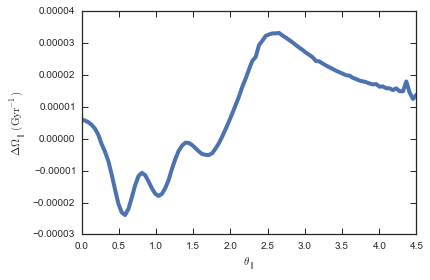

In [10]:
plot(xs,(mO-mO_unp)*bovy_conversion.freq_in_Gyr(V0,R0),lw=4.)
#plot(xs,mO_unp*bovy_conversion.freq_in_Gyr(V0,R0),lw=4.)
xlabel(r'$\theta_\parallel$')
ylabel(r'$\Delta\Omega_\parallel\,(\mathrm{Gyr}^{-1})$')

and the relative density

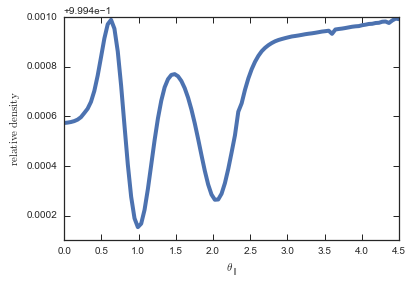

In [11]:
dens= numpy.array([sdf_pepper.density_par(x) for x in xs])
dens_unp= numpy.array([super(galpy.df_src.streampepperdf.streampepperdf,sdf_pepper).density_par(x) for x in xs])
plot(xs,(dens/numpy.sum(dens))/(dens_unp/numpy.sum(dens_unp)),lw=4.)
xlabel(r'$\theta_\parallel$')
ylabel(r'$\mathrm{relative\ density}$')

There's some issues where the stream starts to run out of stars, but overall this works quite well already ...

## Some simulated sets of impacts

Let's look at $10^7\,M_\odot$ first, assuming about 10 impacts:

In [12]:
# Bit of a hack
sdf_pepper._GM= [10.**-3./bovy_conversion.mass_in_1010msol(V0,R0)]
sdf_pepper._rs= [0.25/R0]
# Simulate
sdf_pepper.simulate(rate=10.)

The mean parallel frequency as a function of angle is

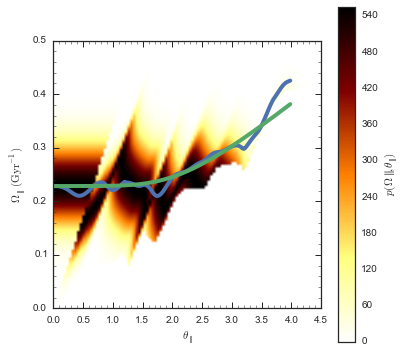

In [13]:
xs= numpy.arange(0.,4.,0.02)
mO= numpy.array([sdf_pepper.meanOmega(x,oned=True) for x in xs])
mO_unp= numpy.array([super(galpy.df_src.streampepperdf.streampepperdf,sdf_pepper).meanOmega(x,oned=True) for x in xs])
Opars= numpy.linspace(0.,0.5,101)/bovy_conversion.freq_in_Gyr(V0,R0)
apars= numpy.linspace(0.,4.5,101)
y= numpy.array([sdf_pepper.pOparapar(Opars,a) for a in apars])
figsize(6,6)
bovy_plot.bovy_dens2d(y.T,
                      origin='lower',
                      cmap='afmhot_r',colorbar=True,
                      vmin=0.,
                      xrange=[apars[0],apars[-1]],
                      yrange=[Opars[0]*bovy_conversion.freq_in_Gyr(V0,R0),
                              Opars[-1]*bovy_conversion.freq_in_Gyr(V0,R0)],
                     zlabel=r'$p(\Omega\parallel,\theta_\parallel)$')
plot(xs,mO*bovy_conversion.freq_in_Gyr(V0,R0),lw=4.)
plot(xs,mO_unp*bovy_conversion.freq_in_Gyr(V0,R0),lw=4.)
xlabel(r'$\theta_\parallel$')
ylabel(r'$\Omega_\parallel\,(\mathrm{Gyr}^{-1})$')

and the density and density contrast is

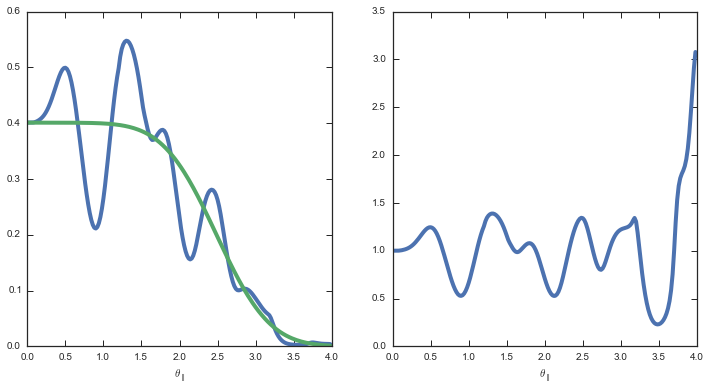

In [14]:
figsize(12,6)
subplot(1,2,1)
dens= numpy.array([sdf_pepper.density_par(x) for x in xs])
dens_unp= numpy.array([super(galpy.df_src.streampepperdf.streampepperdf,sdf_pepper).density_par(x) for x in xs])
plot(xs,dens/numpy.sum(dens)/(xs[1]-xs[0]),lw=4.)
plot(xs,dens_unp/numpy.sum(dens_unp)/(xs[1]-xs[0]),lw=4.)
xlabel(r'$\theta_\parallel$')
subplot(1,2,2)
plot(xs,(dens/numpy.sum(dens))/(dens_unp/numpy.sum(dens_unp)),lw=4.)
xlabel(r'$\theta_\parallel$')

Now let's look at $10^6\,M_\odot$, assuming about 30 impacts. The mean parallel frequency becomes

In [15]:
# Bit of a hack
sdf_pepper._GM= [10.**-4./bovy_conversion.mass_in_1010msol(V0,R0)]
sdf_pepper._rs= [0.1/R0]
# Simulate
sdf_pepper.simulate(rate=30.)

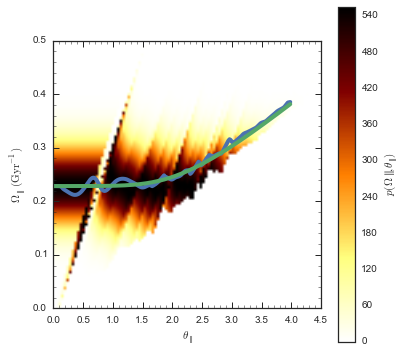

In [16]:
mO_1e6= numpy.array([sdf_pepper.meanOmega(x,oned=True) for x in xs])
Opars= numpy.linspace(0.,0.5,101)/bovy_conversion.freq_in_Gyr(V0,R0)
apars= numpy.linspace(0.,4.5,101)
y= numpy.array([sdf_pepper.pOparapar(Opars,a) for a in apars])
figsize(6,6)
bovy_plot.bovy_dens2d(y.T,
                      origin='lower',
                      cmap='afmhot_r',colorbar=True,
                      vmin=0.,
                      xrange=[apars[0],apars[-1]],
                      yrange=[Opars[0]*bovy_conversion.freq_in_Gyr(V0,R0),
                              Opars[-1]*bovy_conversion.freq_in_Gyr(V0,R0)],
                     zlabel=r'$p(\Omega\parallel,\theta_\parallel)$')
plot(xs,mO_1e6*bovy_conversion.freq_in_Gyr(V0,R0),lw=4.)
plot(xs,mO_unp*bovy_conversion.freq_in_Gyr(V0,R0),lw=4.)
xlabel(r'$\theta_\parallel$')
ylabel(r'$\Omega_\parallel\,(\mathrm{Gyr}^{-1})$')

and the density and density contrast are

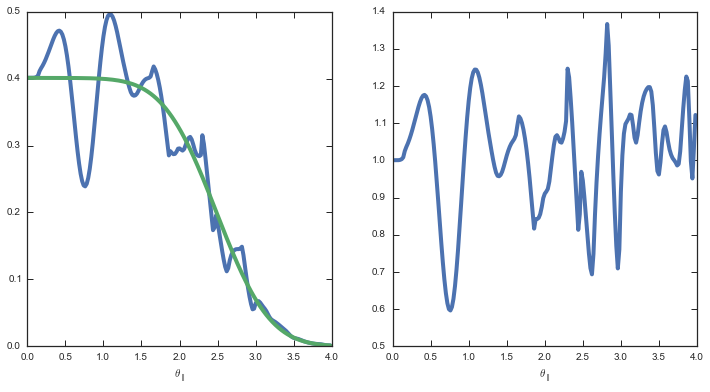

In [17]:
figsize(12,6)
subplot(1,2,1)
dens_1e6= numpy.array([sdf_pepper.density_par(x) for x in xs])
plot(xs,dens_1e6/numpy.sum(dens_1e6)/(xs[1]-xs[0]),lw=4.)
plot(xs,dens_unp/numpy.sum(dens_unp)/(xs[1]-xs[0]),lw=4.)
xlabel(r'$\theta_\parallel$')
subplot(1,2,2)
plot(xs,(dens_1e6/numpy.sum(dens_1e6))/(dens_unp/numpy.sum(dens_unp)),lw=4.)
xlabel(r'$\theta_\parallel$')

Note that there is an issue currently around angle 0.6, where a bunch of the impacts (erroneously) pile up. The power spectrum of the parallel frequency and density differences are given on the diagonal of the following set of plots; the cross power-spectrum is the off-diagonal plot:

/Users/bovy/anaconda/lib/python2.7/site-packages/scipy/signal/spectral.py:767: UserWarning: nperseg = 256, is greater than input length = 99, using nperseg = 99
  'using nperseg = {1:d}'.format(nperseg, x.shape[-1]))



(1e-05, 0.2)

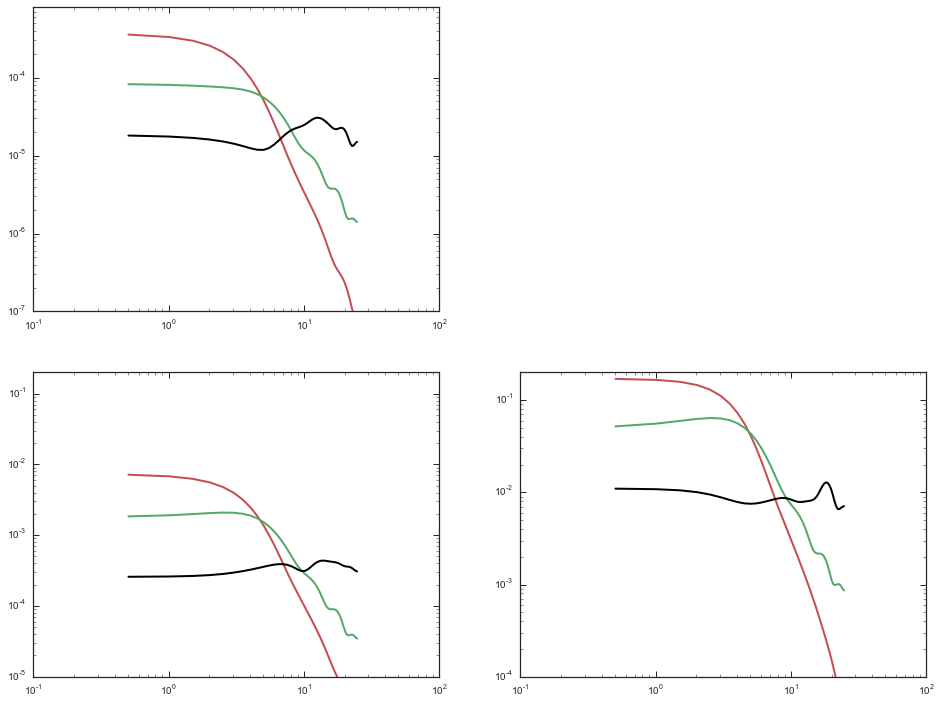

In [18]:
indx= xs > 2. # because we put a bunch at angle=0.1=0.7 now (see dip above)
smooth_len= 3
figsize(16,12)
plotkwargs= {'alpha':1.,'lw':2.}
ppy= signal.welch((mO-mO_unp)[indx]/numpy.linalg.norm(sdf_pepper._progenitor_Omega),
                  fs=1./(xs[1]-xs[0]),scaling='spectrum')
px= ppy[0]
ppy= ndimage.filters.gaussian_filter1d(ppy[1],smooth_len)
subplot(2,2,1)
loglog(px,numpy.sqrt(ppy),color=sns.color_palette()[2],**plotkwargs)
ppy= ndimage.filters.gaussian_filter1d(signal.welch((mO_1e6-mO_unp)[indx]/numpy.linalg.norm(sdf_pepper._progenitor_Omega),
                  fs=1./(xs[1]-xs[0]),scaling='spectrum')[1],smooth_len)
loglog(px,numpy.sqrt(ppy),color=sns.color_palette()[1],**plotkwargs)
ppy= ndimage.filters.gaussian_filter1d(
    signal.welch(numpy.random.normal(size=numpy.sum(indx))*0.0001/numpy.linalg.norm(sdf_pepper._progenitor_Omega),
                  fs=1./(xs[1]-xs[0]),scaling='spectrum')[1],smooth_len)
loglog(px,numpy.sqrt(ppy),color='k',**plotkwargs)
ylim(0.0000001,0.0008)
ppy= ndimage.filters.gaussian_filter1d(signal.welch((dens[indx]/numpy.sum(dens[indx]))/(dens_unp[indx]/numpy.sum(dens_unp[indx])),
                  fs=1./(xs[1]-xs[0]),scaling='spectrum')[1],smooth_len)
subplot(2,2,4)
loglog(px,numpy.sqrt(ppy),color=sns.color_palette()[2],**plotkwargs)
ppy= ndimage.filters.gaussian_filter1d(signal.welch((dens_1e6[indx]/numpy.sum(dens_1e6[indx]))/(dens_unp[indx]/numpy.sum(dens_unp[indx])),
                  fs=1./(xs[1]-xs[0]),scaling='spectrum')[1],smooth_len)
loglog(px,numpy.sqrt(ppy),color=sns.color_palette()[1],**plotkwargs)
ppy= ndimage.filters.gaussian_filter1d(
    signal.welch(numpy.random.normal(size=numpy.sum(indx))*0.05,
                  fs=1./(xs[1]-xs[0]),scaling='spectrum')[1],smooth_len)
loglog(px,numpy.sqrt(ppy),color='k',**plotkwargs)
ylim(0.0001,0.2)
ppy= ndimage.filters.gaussian_filter1d(numpy.absolute(signal.csd((dens[indx]/numpy.sum(dens[indx]))/(dens_unp[indx]/numpy.sum(dens_unp[indx])),
                (mO-mO_unp)[indx]/numpy.linalg.norm(sdf_pepper._progenitor_Omega),
                fs=1./(xs[1]-xs[0]),scaling='spectrum')[1]),smooth_len)
subplot(2,2,3)
loglog(px,numpy.sqrt(ppy),color=sns.color_palette()[2],**plotkwargs)
ppy= ndimage.filters.gaussian_filter1d(numpy.absolute(signal.csd((dens_1e6[indx]/numpy.sum(dens_1e6[indx]))/(dens_unp[indx]/numpy.sum(dens_unp[indx])),
                (mO_1e6-mO_unp)[indx]/numpy.linalg.norm(sdf_pepper._progenitor_Omega),
                fs=1./(xs[1]-xs[0]),scaling='spectrum')[1]),smooth_len)
loglog(px,numpy.sqrt(ppy),color=sns.color_palette()[1],**plotkwargs)
ppy= ndimage.filters.gaussian_filter1d(numpy.absolute(signal.csd(numpy.random.normal(size=numpy.sum(indx))*0.05,
                numpy.random.normal(size=numpy.sum(indx))*0.0001/numpy.linalg.norm(sdf_pepper._progenitor_Omega),
                fs=1./(xs[1]-xs[0]),scaling='spectrum')[1]),smooth_len)
loglog(px,numpy.sqrt(ppy),color='k',**plotkwargs)
ylim(0.00001,0.2)

Taking the power spectra directly without subtracting the smooth stream gives the following. The large scales are now dominated by the smooth-stream structure (also directly computed as the blue line):

(1e-06, 0.02)

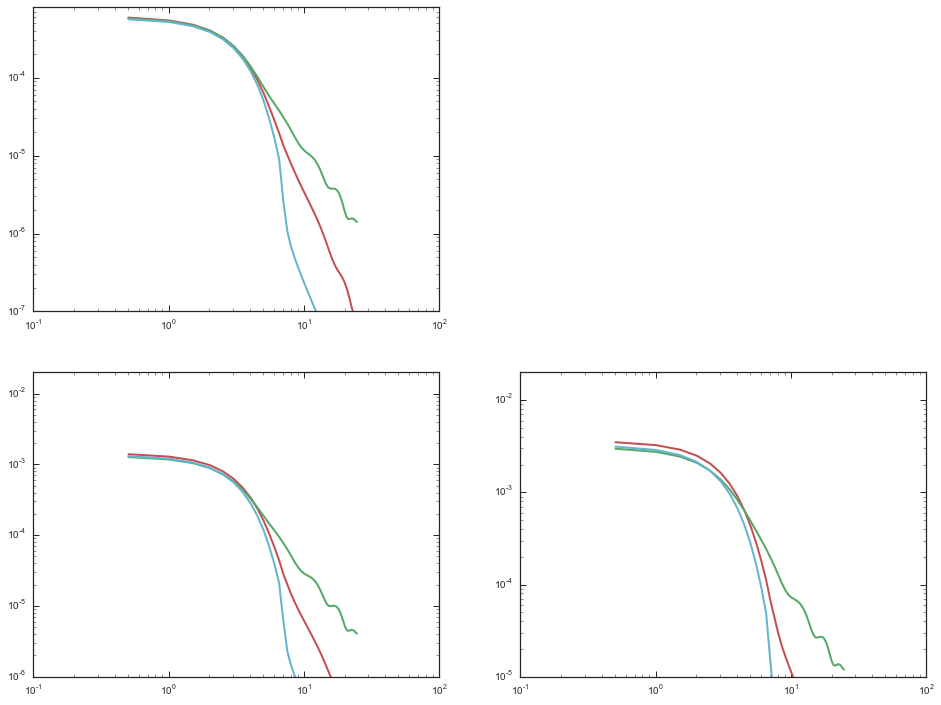

In [19]:
indx= xs > 2. # because we put a bunch at angle=0.1=0.7 now (see dip above)
smooth_len= 3
figsize(16,12)
plotkwargs= {'alpha':1.,'lw':2.}
ppy= signal.welch((mO)[indx]/numpy.linalg.norm(sdf_pepper._progenitor_Omega),
                  fs=1./(xs[1]-xs[0]),scaling='spectrum')
px= ppy[0]
ppy= ndimage.filters.gaussian_filter1d(ppy[1],smooth_len)
subplot(2,2,1)
loglog(px,numpy.sqrt(ppy),color=sns.color_palette()[2],**plotkwargs)
ppy= ndimage.filters.gaussian_filter1d(signal.welch((mO_1e6)[indx]/numpy.linalg.norm(sdf_pepper._progenitor_Omega),
                  fs=1./(xs[1]-xs[0]),scaling='spectrum')[1],smooth_len)
loglog(px,numpy.sqrt(ppy),color=sns.color_palette()[1],**plotkwargs)
ppy= ndimage.filters.gaussian_filter1d(signal.welch((mO_unp)[indx]/numpy.linalg.norm(sdf_pepper._progenitor_Omega),
                  fs=1./(xs[1]-xs[0]),scaling='spectrum')[1],smooth_len)
loglog(px,numpy.sqrt(ppy),color=sns.color_palette()[5],**plotkwargs)
ylim(0.0000001,0.0008)
ppy= ndimage.filters.gaussian_filter1d(signal.welch((dens[indx]/numpy.sum(dens[indx])),
                  fs=1./(xs[1]-xs[0]),scaling='spectrum')[1],smooth_len)
subplot(2,2,4)
loglog(px,numpy.sqrt(ppy),color=sns.color_palette()[2],**plotkwargs)
ppy= ndimage.filters.gaussian_filter1d(signal.welch((dens_1e6[indx]/numpy.sum(dens_1e6[indx])),
                  fs=1./(xs[1]-xs[0]),scaling='spectrum')[1],smooth_len)
loglog(px,numpy.sqrt(ppy),color=sns.color_palette()[1],**plotkwargs)
ppy= ndimage.filters.gaussian_filter1d(signal.welch((dens_unp[indx]/numpy.sum(dens_unp[indx])),
                  fs=1./(xs[1]-xs[0]),scaling='spectrum')[1],smooth_len)
loglog(px,numpy.sqrt(ppy),color=sns.color_palette()[5],**plotkwargs)

ylim(0.00001,0.02)
ppy= ndimage.filters.gaussian_filter1d(numpy.absolute(signal.csd((dens[indx]/numpy.sum(dens[indx])),
                (mO)[indx]/numpy.linalg.norm(sdf_pepper._progenitor_Omega),
                fs=1./(xs[1]-xs[0]),scaling='spectrum')[1]),smooth_len)
subplot(2,2,3)
loglog(px,numpy.sqrt(ppy),color=sns.color_palette()[2],**plotkwargs)
ppy= ndimage.filters.gaussian_filter1d(numpy.absolute(signal.csd((dens_1e6[indx]/numpy.sum(dens_1e6[indx])),
                (mO_1e6)[indx]/numpy.linalg.norm(sdf_pepper._progenitor_Omega),
                fs=1./(xs[1]-xs[0]),scaling='spectrum')[1]),smooth_len)
loglog(px,numpy.sqrt(ppy),color=sns.color_palette()[1],**plotkwargs)
ppy= ndimage.filters.gaussian_filter1d(numpy.absolute(signal.csd((dens_unp[indx]/numpy.sum(dens_unp[indx])),
                (mO_unp)[indx]/numpy.linalg.norm(sdf_pepper._progenitor_Omega),
                fs=1./(xs[1]-xs[0]),scaling='spectrum')[1]),smooth_len)
loglog(px,numpy.sqrt(ppy),color=sns.color_palette()[5],**plotkwargs)
ylim(0.000001,0.02)

In [20]:
print aAI.actionsFreqs(RvR_unp_peri_prog[0],RvR_unp_peri_prog[1],RvR_unp_peri_prog[2]+1./V0,
                      RvR_unp_peri_prog[3]+0.0,RvR_unp_peri_prog[4],RvR_unp_peri_prog[5])[5]-aAI.actionsFreqs(RvR_unp_peri_prog[0],RvR_unp_peri_prog[1],RvR_unp_peri_prog[2],
                      RvR_unp_peri_prog[3]+0.0,RvR_unp_peri_prog[4],RvR_unp_peri_prog[5])[5]


[-0.00122949]
